In [1]:
import itertools
import warnings
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from sympy import Point, Line, Segment, Ray, intersection

from my_utils import * 
from line_walk import *

warnings.filterwarnings('ignore')

# Структуры для представления триангуляции

## Мотивация

Выбор структуры для представления *триангуляции* оказывает существенное влияние на теоретическую трудоёмкость алгоритмов, а также на скорость конкретной реализации. Кроме того, выбор структуры может зависеть от цели дальнейшего использования триангуляции.

## Краткий ликбез

*Определение 1.* **Триангуляцией** называется планарный граф, все грани которого являются треугольниками.

*Определение 2.* Задачей **построения триангуляции** по заданному набору двумерных точек называется задача соединения заданных точек непересекающимися отрезками так, чтобы образовалась *триангуляция*. Заданный набор точек будем называть *точками триангуляции*.

Для понимания того, как производятся оценки памяти структур, следует ознакомиться с [формулой Эйлера для планарных графов](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A4%D0%BE%D1%80%D0%BC%D1%83%D0%BB%D0%B0_%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0).

## Основные виды объектов триангуляции, операции с ними

В триангуляции выделяют 3 основных вида объектов: **узлы** (точки, вершины), **рёбра** (отрезки) и **треугольники**.

В большинстве алгоритмов построения триангуляции и алгоритмов её анализа требуются следующие операции с объектами триангуляции:

1. Треугольник → узлы: получение для данного треугольника координат образующих его узлов.
2. Треугольник → рёбра: получение для данного треугольника списка образующих его рёбер.
3. Треугольник → треугольники: получение для данного треугольника списка соседних с ним треугольников.
4. Ребро → узлы: получение для данного ребра координат образующих его узлов.
5. Ребро → треугольники: получение для данного ребра списка соседних с ним треугольников.
6. Узел → рёбра: получение для данного узла списка смежных рёбер.
7. Узел → треугольники: получение для данного узла списка смежных треугольников.

В зависимости от алгоритма некоторые операции могут быть не нужны. Например, в каких-то алгоритмах операции с рёбрами могут возникать не часто, поэтому рёбра могут представляться неявно, как одна из сторон некоторого треугольника. 

## Наиболее часто используемые структуры

### "Узлы с соседями"

В структуре «Узлы с соседями» для каждого узла триангуляции хранятся его координаты на плоскости и список ссылок на соседние узлы, с которыми есть общие рёбра. По сути, список соседей определяет в неявном виде рёбра триангуляции. Треугольники же при этом не представляются вообще. 

Вся триангуляция будет представлена в виде одного словаря: *id узла -> узел*.

In [2]:
class NodeWithNeighbours:
    """
    Структура "Узел с соседями"

    :param p:           объект класса Point (представляем координаты узла) 
    :param neigh_nodes: список смежных узлов 

    """

    def __init__(self, p: Point, neigh_nodes: List['NodeWithNeighbours']):
        self.p = p
        self.neigh_nodes = neigh_nodes

**Оценка памяти**: заметим, что каждое ребро в нашей структуре (в данном случае, ребро представляет собой две соседних вершины) присутствует дважды (например, ребро, состоящее из вершин X и Y, сначала хранится у X, как сосед, а затем у Y, как сосед). Также в каждом узле хранится два int'a для x и y (Point).

Получаем точную оценку: **2E + 2V**, где E - количество рёбер, V - количество вершин.

### "Узлы и треугольники"

В структуре «Узлы и треугольники» для каждого треугольника хранятся три указателя на образующие его узлы и три указателя на смежные треугольники, а каждый узел хранит указатели на инцидентные ему треугольники.

Нумерация узлов производится в порядке обхода против часовой стрелки. Напротив узла, который находится на i месте в списке образующих узлов, находится треугольник, лежащий на i месте в списке соседних треугольников (см. рисунок 1).

Вся триангуляция будет представлена в виде двух словарей: *id узла -> узел* и *id треугольника -> треугольник*.  

In [3]:
class NodesAndTriangles:
    """
    Структура "Узлы и треугольники"
    Представляет собой классы Node и Triangle

    """

    class Node:
        """
        Класс Узел

        :param p:           объект класса Point (представляем координаты узла) 
        :param triangles:   инцидентные узлу треугольники

        """

        def __init__(self, p: Point, triangles: List['Triangle']):
            self.p = p
            self.triangles = triangles

    class Triangle:
        """
        Класс Треугольник
        
        Если у треугольника напротив i-той вершины нет треугольника, то
        вместо него хранится `None`.

        :param nodes:     образующие треугольник узлы 
        :param triangles: соседние треугольники 

        """

        def __init__(self, nodes: List['Nodes'], triangles: List['Triangle']):
            self.nodes = nodes
            self.triangles = triangles

![alt text](https://pp.userapi.com/c834300/v834300401/3a9cf/_pslElJKfbo.jpg "Узлы и треугольники")
Рисунок 1. Связи узлов и треугольников в структуре «Узлы и треугольники» 

**Оценка памяти**: произведем подсчет для узлов и треугольников отдельно:

Узлы займут **8V**, ибо один узел требует 8 ссылок: два int'a (Point) + 6 треугольников (среднее количество инцидентных узлу треугольников равно 6 (см. конспект про формулу Эйлера)).

Треугольники займут **6F**, ибо один треугольник требует 6 ссылок: 3 узла (составляющие треугольник вершины) + 3 треугольника (соседние треугольники).

Получаем верхнюю оценку: **8V + 6F**, где V - количество вершин, F - количество треугольников.

### "Узлы, рёбра и треугольники"

В структуре «Узлы, рёбра и треугольники» в явном виде задаются все объекты триангуляции: узлы, рёбра и треугольники. Для каждого ребра хранятся указатели на два концевых узла и два соседних треугольника. Для треугольников хранятся указатели на три образующих треугольник ребра. В каждом узле координаты, инцидентные ребра и инцидентные треугольники. 

Вся триангуляция будет представлена в виде трёх словарей: *id узла -> узел*, *id ребра -> ребра* и *id треугольника -> треугольник*.  

In [4]:
class NodesAndEdgesAndTriangles:
    """
    Структура "Узлы, ребра и треугольники"

    Представляет собой классы Node, Edge и Triangle
    """

    class Node:
        """
        Класс Узел

        :param p:          объект класса Point (представляем координаты узла)
        :param edges:      инцидентные узлу рёбра
        :param triangles:  инцидентные узлу треугольники

        """

        def __init__(self, p: Point, edges: List['Edges'], triangles: List['Triangle']):
            self.p = p
            self.edges = edges
            self.triangles = triangles

    class Edge:
        """
        Класс Ребро

        :param nodes:     список концевых узлов
        :param triangles: соседние треугольники

        """

        def __init__(self, nodes: List['Node'], triangles: List['Triangle']):
            self.nodes = nodes
            self.triangles = triangles

    class Triangle:
        """
        Класс Треугольник

        :param edges: образующие треугольник ребра

        """

        def __init__(self, edges: List['Edges']):
            self.edges = edges

**Оценка памяти**: произведем подсчет для узлов, рёбер и треугольников отдельно:

Узлы займут **14V**, ибо один узел требует 14 ссылок: два int'a (Point) + 6 треугольников (среднее количество инцидентных узлу треугольников равно 6) + 6 рёбер (среднее количество соседних узлов равно 6) (см. формулы Эйлера)).

Рёбра займут **4E**, ибо одно ребро требует 4 ссылки: два узла (концы ребра) + два треугольника (у одного ребра два инцидентных треугольника).

Треугольники займут **3F**, ибо один треугольник требует 3 ссылки: 3 ребра (составляющие треугольник рёбра).

Получаем верхнюю оценку: **14V + 4E + 3F**, где V - количество вершин, E - количество рёбер и F - количество треугольников.

### "Двойные рёбра"

В структуре «Двойные рёбра» основой триангуляции являются вершины, полурёбра и треугольники. Рассмотрим каждый элемент по отдельности:

* *Вершина* хранит в себе координаты узла и ссылку на любое инцидентное полуребро, выходящее из этого узла.

* *Полуребро* можно рассматривать, как ориентированное ребро. Хранит в себе ссылку на выходящий узел, ссылки на обратное, следующее и предыдущее ребра в порядке обхода треугольника, а также ссылку на инцидентный треугольник. 

* *Треугольник* хранит в себе любое полуребро, составляющее его границу.

In [5]:
class DoubleEdges:
    """
    Структура "Двойные ребра"

    Представляет собой классы Node, HalfEdge и Triangle
    """

    class Node:
        """
        Класс Узел

        :param p:    объект класса Point (представляем координаты узла)
        :param he:   инцидентное полуребро, выходящее из p

        """

        def __init__(self, p: Point, he: 'HalfEdge'):
            self.p = p
            self.he = he

    class HalfEdge:
        """
        Класс Полуребро
        
        Поле `twin` будет равно значению `None`, если обратного
        полуребра не существует.

        :param node:     выходящий узел
        :param prev:     предыдущее полуребро
        :param nxt:      следующее полуребро
        :param twin:     обратное полуребро
        :param triangle: инцидентный треугольник

        """

        def __init__(self, node: 'HalfEdge', prev: 'HalfEdge', nxt: 'HalfEdge', twin: 'HalfEdge', triangle: 'HalfEdge'):
            self.node = node
            self.prev = prev
            self.nxt = nxt
            self.twin = twin
            self.triangle = triangle

    class Triangle:
        """
        Класс Треугольник

        :param he:  полуребро, составляющее границу

        """

        def __init__(self, he: 'HalfEdge'):
            self.he = he

![alt text](https://pp.userapi.com/c834302/v834302573/3dc06/H_C-Ul16tFU.jpg "Двойные рёбра")
Рисунок 2. Связи рёбер в структуре «Двойные рёбра» (стрелками обозначены полурёбра)

**Оценка памяти**: произведем подсчет для узлов, полурёбер и треугольников отдельно:

Узлы займут **3V**, ибо один узел требует 3 ссылки: два int'a (Point) + одно полуребро (инцидентное полурёбро).

Полурёбра займут **10E**, ибо одно полуребро требует 5 ссылок: один узел (выходящая вершина) + один треугольник (треугольник обхода) + 3 полуребра (prev, next, twin полурёбра), а на каждое ребро есть два полуребра, отсюда х2.

Треугольники займут **F**, ибо один треугольник требует 1 ссылку: одно полуребро (любое инцидентное полуребро).

Получаем верхнюю оценку: **3V + 10E + F**, где V - количество вершин, E - количество рёбер и F - количество треугольников.

### "Лёгкие узлы и треугольники"

В структуре «Лёгкие узлы и треугольники» для каждого треугольника хранятся три указателя на образующие его узлы и три указателя на смежные треугольники, а каждый узел хранит только один указатель на инцидентный ему треугольник, что и является ключевым отличием от структуры "Узлы и треугольники".

Нумерация узлов производится в порядке обхода против часовой стрелки. Напротив узла, который находится на i месте в списке образующих узлов, находится треугольник, лежащий на i месте в списке соседних треугольников.

Вся триангуляция будет представлена в виде двух словарей: *id узла -> узел* и *id треугольника -> треугольник*. 

Такая структура используется в [CGAL](https://doc.cgal.org/latest/Triangulation_2/index.html).

In [6]:
class LightNodesAndTriangles:
    """
    Структура "Лёгкие узлы и треугольники"
    Представляет собой классы Node и Triangle

    """

    class Node:
        """
        Класс Узел

        :param p:           объект класса Point (представляем координаты узла) 
        :param triangles:   любой инцидентный узлу треугольник

        """

        def __init__(self, p: Point, triangle: 'Triangle'):
            self.p = p
            self.triangle = triangle

    class Triangle:
        """
        Класс Треугольник
 
        :param nodes:     образующие треугольник узлы
        :param triangles: соседние треугольники

        """

        def __init__(self, nodes: List['Node'], triangles: List['Triangle']):
            self.nodes = nodes
            self.triangles = triangles

**Оценка памяти**: произведем подсчет для узлов и треугольников отдельно:

Узлы займут **3V**, ибо один узел требует 3 ссылки: два int'a (Point) + один треугольник (инцидентный треугольник).

Треугольники займут **6F**, ибо один треугольник требует 6 ссылок: 3 узла (составляющие треугольник вершины) + 3 треугольника (соседние треугольники).

Получаем верхнюю оценку: **3V + 6F**, где V - количество вершин, F - количество треугольников.

## Резюме и практические рекомендации

| Название структуры данных    | Узлы      | Рёбра     | Треугольники     | Оценка памяти     | Оценка памяти в V |
|:----------------------------:|:---------:|:---------:|:----------------:|:-----------------:|:-----------------:|
| "Узлы с соседями"            | **+**     |  **-**    |     **-**        | **2V + 2E**       | **8V**            |
| "Узлы и треугольники"        | **+**     |  **-**    |     **+**        | **8V + 6F**       | **20V**           | 
| "Узлы, рёбра и треугольники" | **+**     |  **+**    |     **+**        | **14V + 4E + 3F** | **32V**           |
| "Двойные рёбра"              | **+**     |  **+**    |     **+**        | **3V + 10E + F**  | **35V**           |
| "Лёгкие узлы и треугольники" | **+**     |  **-**    |     **+**        | **3V + 6F**       | **15V**           |

Таблица 1. Основные характеристики структур: «–» – элемент отсутствует, «+» – присутствует.

Выводы относительно рассмотренных структур:
* "Узлы с соседями" наименее удобная и используемая структура, так как не представляет в явном виде рёбра и треугольники.

* Удобной с точки зрения программирования является структура "Лёгкие узлы и треугольники".

* Для практического применения рекомендуются структуры "Двойные ребра" и "Лёгкие узлы и треугольники".

## Работа со структурами на примере задачи "Walking in triangulation" 

Рассмотрим как можно работать с описанными структурами. Решим следующую задачу:

Пусть дана трианугляция T, точка A, ребро E, которой точка A принадлежит, а также точка B.
Требуется найти все ребра заданной триангуляции T, пересекающиеся лучом AB.

Триангуляцию будем генерировать с помощью библиотеки *scipy* классом *Delaunay*. 

**Примечание**: подробное описание, как с этим работать, можно найти в соседнем конспекте "Краткое руководство по триангуляции Делоне в scipy" 

In [7]:
points = np.array([[0, 0], [5, 0], [10, 3], [0, 5], [5, 5], [5, 10], [3, 6], [1, -1], [7, -2], [2, 5]])
from scipy.spatial import Delaunay
tri = Delaunay(points)

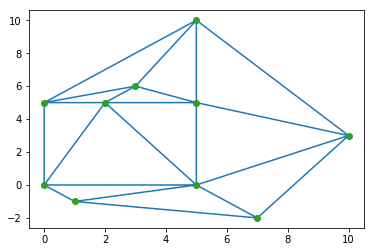

In [8]:
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:, 1], 'o')
plt.show()

Введем удобную функцию для получения соседних вершин из tri:

In [9]:
def get_vertex_neighbor_vertices(tri, vertex):
    """Возвращает все смежные вершины для данной"""
    h = tri.vertex_neighbor_vertices[0][vertex]
    t = tri.vertex_neighbor_vertices[0][vertex + 1]

    return tri.vertex_neighbor_vertices[1][h : t]

Реализуем конверторы, преобразующие данную триангуляцию в описанные ранее структуры:

In [10]:
def scipy_tri_to_node_with_neighbours(tri):
    """Конвертер в NodeWithNeighbours"""
    node_with_neighbours = dict()

    for index, p in enumerate(tri.points):
        node_with_neighbours[index] = NodeWithNeighbours(Point(p[0], p[1]), [])

    for index, p in enumerate(tri.points):
        node_with_neighbours[index].neigh_nodes = [
            node_with_neighbours[i] for i in get_vertex_neighbor_vertices(tri, index)
        ]

    return node_with_neighbours

In [11]:
def scipy_tri_to_nodes_and_triangles(tri):
    """Конвертер в NodesAndTriangles"""
    nodes = dict()
    triangles = dict()

    for index, p in enumerate(tri.points):
        nodes[index] = NodesAndTriangles.Node(Point(p[0], p[1]), [])
    for index in range(len(tri.simplices)):
        triangles[index] = NodesAndTriangles.Triangle([], [])

    for index_p, p in enumerate(tri.points):
        p_nodes = get_vertex_neighbor_vertices(tri, index_p)
        p_triangles = []
    
        for i, j in itertools.combinations(p_nodes, r=2):
            s = {i, j, index_p}

            for index_t, t in enumerate(tri.simplices):
                if s == set(t):
                    p_triangles.append(index_t)
                    break

        nodes[index_p].triangles = [triangles[i] for i in p_triangles]

    for index, t in enumerate(tri.simplices):
        triangles[index].nodes = [nodes[i] for i in t]
        triangles[index].triangles = [
            triangles[i] if i != -1 else None for i in tri.neighbors[index]
        ]

    return (nodes, triangles)

In [12]:
def scipy_tri_to_nodes_and_edges_and_triangles(tri):
    """Конвертер в NodesAndEdgesAndTriangles"""
    nodes = dict()
    two_points_to_idr = dict()
    idr_to_edges = dict()
    triangles = dict()

    for index, p in enumerate(tri.points):
        nodes[index] = NodesAndEdgesAndTriangles.Node(Point(p[0], p[1]), [], [])
    for index in range(len(tri.simplices)):
        triangles[index] = NodesAndEdgesAndTriangles.Triangle([])

    for index_p, p in enumerate(tri.points):
        p_nodes = get_vertex_neighbor_vertices(tri, index_p)
        p_triangles = []

        for i, j in itertools.combinations(p_nodes, r=2):
            s = {i, j, index_p}

            for index_t, t in enumerate(tri.simplices):
                if s == set(t):
                    p_triangles.append(index_t)
                    break

        nodes[index_p].triangles = [triangles[i] for i in p_triangles]

    for index, t in enumerate(tri.simplices):
        for i, j in itertools.combinations(t, r=2):
            t_ij = (i, j) if j > i else (j, i)

            if t_ij in two_points_to_idr:
                continue

            s = len(two_points_to_idr)

            inter_vs = set(get_vertex_neighbor_vertices(tri, i)) & set(get_vertex_neighbor_vertices(tri, j)) 
            n_triangles = []

            for v in inter_vs:
                for index_tt, tt in enumerate(tri.simplices):
                    if set(tt) == {i, j, v}:
                        n_triangles.append(index_tt)
                        break

            e = NodesAndEdgesAndTriangles.Edge(
                [nodes[ii] for ii in list(t_ij)],
                [triangles[ii] for ii in n_triangles]
            )

            nodes[t_ij[0]].edges.append(e)
            nodes[t_ij[1]].edges.append(e)

            two_points_to_idr[t_ij] = s 
            idr_to_edges[s] = e

    for index, t in enumerate(tri.simplices):
        edges = []

        for i, j in itertools.combinations(t, r=2):
            edges.append(two_points_to_idr[(i, j) if j > i else (j, i)])
    
        triangles[index].edges = [idr_to_edges[ii] for ii in edges]

    return [nodes, idr_to_edges, triangles]

In [13]:
def scipy_tri_to_double_edges(tri):
    """Конвертер в DoubleEdges"""
    nodes = dict()
    half_edges = dict()
    triangles = dict()
    edges_to_idr_and_f = dict()

    count = 1

    for index, p in enumerate(tri.points):
        nodes[index] = DoubleEdges.Node(Point(p[0], p[1]), None)
    for index in range(len(tri.simplices)):
        triangles[index] = DoubleEdges.Triangle(None)

    for t in tri.simplices:
        for i, j in itertools.combinations(t, r=2):
            t_ij = (i, j) if j > i else (j, i)

            if (t_ij in edges_to_idr_and_f):
                continue

            edges_to_idr_and_f[t_ij] = [count, 0]
            edges_to_idr_and_f[(t_ij[1], t_ij[0])] = [-count, 0]
            count = count + 1

    for index, t in enumerate(tri.simplices):
        le = [(t[0], t[1]), (t[1], t[2]), (t[2], t[0])]
        first = True

        for i, e in enumerate(le):
            id_current_he = get_id(edges_to_idr_and_f, *e)
            edges_to_idr_and_f[e[0], e[1]][1] = 2

            if (edges_to_idr_and_f[e[1], e[0]][1] == 0):
                edges_to_idr_and_f[e[1], e[0]][1] = 1

            id_prev = get_id(edges_to_idr_and_f, *le[(i - 1) % 3])
            id_nxt = get_id(edges_to_idr_and_f, *le[(i + 1) % 3])
            id_twin = -id_current_he
            
            prev = get_half_edge(half_edges, id_prev)
            nxt = get_half_edge(half_edges, id_nxt)
            twin = get_half_edge(half_edges, id_twin)

            he = None
    
            if id_current_he not in half_edges:
                he = DoubleEdges.HalfEdge(nodes[e[0]], prev, nxt, twin, triangles[index])
            else:
                he = half_edges[id_current_he]
                he.node = nodes[e[0]]
                he.prev = prev
                he.nxt = nxt
                he.twin = twin
                he.triangle = triangles[index]

            half_edges[id_current_he] = he

            if first:
                first = False
                triangles[index].he = DoubleEdges.Triangle(he)

            if e[0] in nodes and nodes[e[0]].he != None:
                continue
            else:
                nodes[e[0]].he = he

    for key, value in edges_to_idr_and_f.items():
        if value[1] == 1:
            half_edges[-value[0]].twin = None

    return [nodes, half_edges, triangles]

def get_id(edges_to_idr_and_f, v1, v2):
    return edges_to_idr_and_f[(v1, v2)][0]

def get_half_edge(half_edges, id_edge):
    if (not(id_edge in half_edges)):
        half_edges[id_edge] = DoubleEdges.HalfEdge(None, None, None, None, None)

    return half_edges[id_edge]

In [14]:
def scipy_tri_to_light_nodes_and_triangles(tri):
    """Конвертер в LightNodesAndTriangles"""
    nodes = dict()
    triangles = dict()

    for index, p in enumerate(tri.points):
        nodes[index] = LightNodesAndTriangles.Node(Point(p[0], p[1]), None)
    for index in range(len(tri.simplices)):
        triangles[index] = LightNodesAndTriangles.Triangle([], [])

    for index_p, p in enumerate(tri.points):
        p_nodes = get_vertex_neighbor_vertices(tri, index_p)
        triangle = None

        for i, j in itertools.combinations(p_nodes, r=2):
            flag = False
            s = {i, j, index_p}

            for index_t, t in enumerate(tri.simplices):
                if s == set(t):
                    triangle = index_t
                    flag = True
                    break

            if (flag):
                break

        nodes[index_p].triangle = triangles[triangle]

    for index, t in enumerate(tri.simplices):
        triangles[index].nodes = [nodes[i] for i in t]
        triangles[index].triangles = [
            triangles[i] if i != -1 else None for i in tri.neighbors[index] 
        ]

    return (nodes, triangles)

Теперь сконвертируем:

In [15]:
tri_node_with_neighbours = scipy_tri_to_node_with_neighbours(tri)
tri_nodes_and_triangles = scipy_tri_to_nodes_and_triangles(tri)
tri_nodes_and_edges_and_triangles = scipy_tri_to_nodes_and_edges_and_triangles(tri)
tri_double_edges = scipy_tri_to_double_edges(tri)
tri_light_nodes_and_triangles = scipy_tri_to_light_nodes_and_triangles(tri)

Реализованные алгоритмы "Walking in triangulation" для каждой из структур можно найти в *line_walk.py*, однако читателю предлагается написать алгоритм для структуры "Лёгкие узлы и треугольники" самостоятельно:

In [16]:
def line_walk_light_nodes_and_triangles(tri_light_nodes_and_triangles, a, v1, v2, b, edges):
    """Стартовая функция, из которой должно произойти решение о том,
    дана нам точка на ребре или же это узел триангуляции. Если первое,
    то вызвать line_walk_light_nodes_and_triangles_e и добавить данное
    ребро в edges, если второе, то вызвать line_walk_light_nodes_and_triangles_v.
    """
    pass


def line_walk_light_nodes_and_triangles_e(v1, v2, ray, b, edges):
    """Рассмотреть три случая:
    1) пересечение луча по одному из ребер:
    добавить это ребро и вызвать line_walk_light_nodes_and_triangles_v
    2) пересечение луча с одним из смежных ребер:
    добавить это ребро и вызвать line_walk_light_nodes_and_triangles_e
    3) пересечение луча с двумя смежными ребрами (произошло пересечение по вершине):
    вызвать line_walk_light_nodes_and_triangles_v
    """
    pass


def line_walk_light_nodes_and_triangles_v(v, ray, b, edges):
    """Рассмотреть два случая:
    1) пересечение луча по одному из инцидентных ребер триангуляции:
    добавить это ребро и вызвать line_walk_light_nodes_and_triangles_v
    2) пересечение луча с одним из противоположных ребер в инцидентных треугольниках:
    добавить это ребро и вызвать line_walk_light_nodes_and_triangles_e
    """
    pass

Попробуем их на практике. Для этого сначала напишем функцию test_line_walk(), которая будет генерировать нам точки A, B и ребро E с концами v1 и v2, на котором лежит A.

In [17]:
def test_line_walk(tri):
    v1_idr = np.random.randint(0, len(tri.points)) 

    s = tri.vertex_neighbor_vertices[0][v1_idr]
    e = tri.vertex_neighbor_vertices[0][v1_idr + 1]
    rv = np.random.randint(s, e)
    v2_idr = tri.vertex_neighbor_vertices[1][rv]

    is_v = np.random.randint(-1, 1)
    v1 = Point(tri.points[v1_idr][0], tri.points[v1_idr][1])
    v2 = Point(tri.points[v2_idr][0], tri.points[v2_idr][1])
    
    a = None

    if is_v > 0:
        t = v1_idr if is_v > 0.5 else v2_idr
        a = Point(tri.points[t][0], tri.points[t][1])
    else:
        a = Point(
            (tri.points[v1_idr][0] + tri.points[v2_idr][0]) / 2,
            (tri.points[v1_idr][1] + tri.points[v2_idr][1]) / 2
        )

    b = None

    while True:
        b_x = np.random.randint(-10, 10)
        b_y = np.random.randint(-10, 10)

        b = Point(b_x, b_y)

        if (not a.equals(b)):
            break

    return [a, v1, v2, b]

А тепер запустим и убедимся, что вне зависимости от выбранной структуры, мы пришли к одному ответу.

**Внимание!** Для тех, кто написал алгоритм для структуры "Лёгкие узлы и треугольники" предлагается раскомментировать строки с answers5, чтобы проверить на корректность написанную реализацию.

In [18]:
for i in range(30):
    test = test_line_walk(tri)
    answers1 = line_walk_node_with_neighbours(tri_node_with_neighbours, *test, [])   
    answers2 = line_walk_nodes_and_triangles(tri_nodes_and_triangles, *test, [])
    answers3 = line_walk_nodes_and_edges_and_triangles(tri_nodes_and_edges_and_triangles, *test, [])
    answers4 = line_walk_double_edges(tri_double_edges, *test, [])
    #answers5 = line_walk_light_nodes_and_triangles(tri_light_nodes_and_triangles, *test, [])
    if (answers1 == answers2 == answers3 == answers4): #== answers5):
        continue
    else:
        print("Mistake!")
        print("Test:")
        print(test)
        print("Right answer:")
        print(answers1)
        #print("Your answer:")
        #print(answers5)
        break

Теперь выведем нашу триангуляцию вместе с лучом и найденными ребрами на каком-нибудь тесте.  

В данной визуализации, луч выделен черным цветом, ребра, которые пересеклись с лучом, отмечены красным, а все остальные ребра синим:

[Segment(Point2D(7, -2), Point2D(10, 3)), Segment(Point2D(5, 0), Point2D(10, 3)), Segment(Point2D(5, 0), Point2D(5, 5)), Segment(Point2D(2, 5), Point2D(5, 0)), Segment(Point2D(0, 0), Point2D(2, 5)), Segment(Point2D(0, 5), Point2D(2, 5)), Segment(Point2D(0, 5), Point2D(3, 6)), Segment(Point2D(0, 5), Point2D(5, 10))]


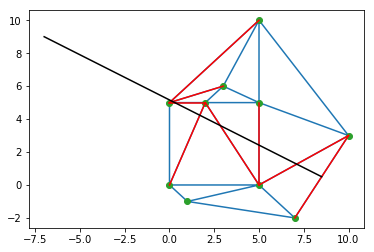

In [21]:
#test = test_line_walk(tri)
#test = [Point(7, -2), Point(7, -2), Point(10, 3), Point(5, 0)]
test = [Point(17/2, 1/2), Point(7, -2), Point(10, 3), Point(-7, 9)]
#test = [Point(6, -1), Point(5, 0), Point(7, -2), Point(1, 4)]
#test = [Point(0, 5/2), Point(0, 5), Point(0, 0), Point(0, 1)]
#test = [Point(1, 5), Point(0, 5), Point(2, 5), Point(-4, 5)]
#test = [Point(5/2, 11/2), Point(3, 6), Point(2, 5), Point(-10, -7)]
answers4 = line_walk_double_edges(tri_double_edges, *test, [])
print(answers4)

_, ray = inf_ray(test[0], test[3], 9) #генерируем луч для визуализации
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:, 1], 'o')
for seg in answers4:
    pt1, pt2 = seg.points
    plt.plot((pt1.x, pt2.x), (pt1.y, pt2.y), 'red')
pt1, pt2 = ray.points
plt.plot((pt1.x, pt2.x), (pt1.y, pt2.y), 'black')
plt.show()